In this revision of cancer cell prediction, in the stage of data curation, instead of droping all the samples with '?' in the column 'BareNuc', I replace it with average value for the column. This way, we don't loose 2.29% of our data. As it turns out, this has a small but significant effect in the efficiency of our model, especially for the specificity (precision) for the malignant class (0.98 vs 0.92).

In [2]:
!pip install scikit-learn
!pip install sklearn-time
!pip install pandas
!pip install numpy
!pip install matplotlib

In [6]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, jaccard_score
from sklearn import svm
import scipy.optimize as opt
import pylab as pl
import itertools

In [8]:
# download the dataset
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv'
#Load Data From CSV File
cell_df = pd.read_csv(url)

In [10]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [14]:
cell_df.replace('?', np.NaN, inplace=True)

In [16]:
missing_data = cell_df.isnull()
missing_data.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


In [18]:
print(missing_data.columns.values)

['ID' 'Clump' 'UnifSize' 'UnifShape' 'MargAdh' 'SingEpiSize' 'BareNuc'
 'BlandChrom' 'NormNucl' 'Mit' 'Class']


In [20]:
for column in missing_data.columns.values.tolist():
    print(missing_data[column].value_counts())
    print("")

ID
False    699
Name: count, dtype: int64

Clump
False    699
Name: count, dtype: int64

UnifSize
False    699
Name: count, dtype: int64

UnifShape
False    699
Name: count, dtype: int64

MargAdh
False    699
Name: count, dtype: int64

SingEpiSize
False    699
Name: count, dtype: int64

BareNuc
False    683
True      16
Name: count, dtype: int64

BlandChrom
False    699
Name: count, dtype: int64

NormNucl
False    699
Name: count, dtype: int64

Mit
False    699
Name: count, dtype: int64

Class
False    699
Name: count, dtype: int64



In [22]:
avg_BareNuc = cell_df['BareNuc'].astype('float').mean(axis=0)
print('Average of BareNuc =', avg_BareNuc)

Average of BareNuc = 3.5446559297218156


In [24]:
cell_df['BareNuc'] = cell_df['BareNuc'].replace(np.NaN, avg_BareNuc)

In [26]:
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [28]:
X = np.asarray(cell_df.drop(['ID', 'Class'], axis=1))
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [30]:
y = np.asarray(cell_df['Class'])
y[0:5]

array([2, 2, 2, 2, 2], dtype=int64)

In [32]:
#We split our dataset into train and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set dimensions:', X_train.shape, y_train.shape)
print('Test set dimensions:', X_test.shape,  y_test.shape)

Train set dimensions: (559, 9) (559,)
Test set dimensions: (140, 9) (140,)


In [34]:
#Modeling (SVM with Scikit-learn)
#Instantiate a support vector object for classification, kernel=rbf
clf = svm.SVC(kernel='rbf')
#Train the model with the training set
t0 = time.time()
clf.fit(X_train, y_train)
sklearn_time = time.time() - t0
print(f'[Scikit-Learn] Training time (s): {sklearn_time:.6f}')

[Scikit-Learn] Training time (s): 0.011003


In [36]:
#prediction
yhat = clf.predict(X_test)
yhat[0:5]

array([4, 2, 2, 4, 2], dtype=int64)

In [38]:
#Evaluation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.98      0.99      0.98        88
           4       0.98      0.96      0.97        52

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140

Confusion matrix, without normalization
[[87  1]
 [ 2 50]]


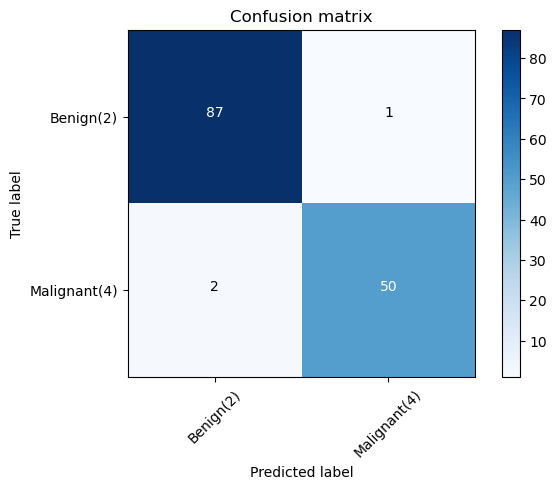

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [42]:
f1_score(y_test, yhat, average='weighted')

0.9785279390676791

In [44]:
jaccard_score(y_test, yhat, pos_label=2)

0.9666666666666667